In [1]:
import warnings

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from Functions import pmfg
import seaborn as sns

import Classes

warnings.filterwarnings('ignore')
%matplotlib inline


df = pd.read_excel("Credit risk exposures and exposures to sovereigns a.xlsx", 
                   header=1, index_col=0)
df = df.iloc[:, 0:8]
df = df.drop("4. Total retail", axis = 1)
df.columns = ["1_Sov", "2_Fin", "3_Corp", "4-1_Ret_Res", "4-2_Ret_Rev", "4-3_Ret_SME", "5_CRE"]


bank_names_df = pd.read_csv("BankCodes.csv", index_col=0).iloc[:, 0].to_frame("Name")
bank_cap_df = pd.read_excel("Tier-1 CRs 2010.xlsx", 
                       header=2, index_col=1).iloc[:, 1].to_frame("Capital")
df = pd.concat([df, bank_names_df, bank_cap_df], axis=1)

sd_df = pd.read_excel("EU_SOV_Debt_Bank_Net_2011.xlsx", header=0, index_col=0).T
sd_df.loc[:, u"XX"] = np.maximum(df.iloc[:, 0] - sd_df.apply(np.sum, axis=1), 0)
sd_df.columns = sd_df.columns.rename("SD_Name")
sd_names = [sd.encode('ascii', 'ignore') for sd in sd_df.columns]


spread = [20, 55, 60, 130, 30, 5, 15, 40, 115, 10, 40, 25, 1400, 80, 315, 35,
          100, 20, 55, 40, 55, 50, 100, 20, 10, 50, 400, 70, 10, 30, 25, 20, 50]
spread_df = pd.DataFrame(data=spread, index=sd_names, columns=["spread"])
spread_df.loc[:, "Q"] = spread_df.loc[:, "spread"].apply(Classes.Q)

geo_df = sd_df.div(sd_df.apply(np.sum, axis=1), axis=0)

sns.set_style("whitegrid")

In [277]:
start_country = \
[['GR','IT','PT','IE','ES'], # 0
 ['BG','CZ','EE','HU','LT','LV','PL','SI','RO','SK'], # 1
 ['BE','NL','LU'], # 2
 ['GR'], # 3
 ['IT'], # 4
 ['FR'], # 5
 ['DE'], # 6
 ['ES'], # 7
 ['US'], # 8
 ['JP']] # 9

sector_list = ['sov', 'fin', 'corp', 'ret_res', 'ret_rev', 'ret_sme', 'cre']

In [184]:
world = Classes.World(df, geo_df, spread_df, 0.6, Classes.RiskWeights("min"))
sect_dict = world.getSectorDict()

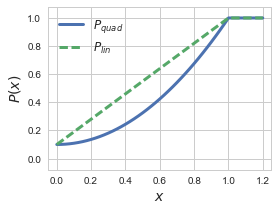

In [417]:
reload(Classes);

fig, ax = plt.subplots(figsize=(4,3))
ax.set_ylim(-0.08, 1.08)
ax.set_xlim(-0.05, 1.25)
ax.set_xlabel("$x$", fontsize=14)
ax.set_ylabel("$P(x)$", fontsize=14)
plt.plot(np.arange(0,1.225, 0.025), Classes.P(np.arange(0,1.225, 0.025)), linewidth=3, label="$P_{quad}$")
plt.plot(np.arange(0,1.225, 0.025), Classes.P_lin(np.arange(0,1.225, 0.025)), linewidth=3,  linestyle='--', label="$P_{lin}$")
plt.legend(loc=2, fontsize=12)
fig.savefig("./img/px.png", transparent=True, bbox_inches='tight')

In [ ]:
for ct in range(1,10):
    country_str = "_".join(np.sort(start_country[ct]))
    if len(start_country[ct]) == 1:
        plot_title = start_country[ct][0]
    else:
        plot_title = ", ".join(start_country[ct])

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(9,16))
    fig.suptitle("Beginning crisis in " + plot_title, fontsize=24)
    
    ax_dict = {2:ax2, 3:ax3, 4:ax4, 5:ax5, 6:ax6, 7:ax7, 8:ax8}
    
    ax=ax1
    try:
        df = pd.read_csv("Output/BankShock__Phase_Diagram__quad__"+country_str+".csv")
        
        sct = ax.scatter(df.sp, df.x, c=df.cr, s=40, alpha=0.8, cmap='plasma')
        cb = plt.colorbar(sct, ax=ax)
        cb.set_label('Initial Capital Loss', fontsize=12)
        
        ax.set_title("\nShocking Banks", 
                     fontdict={'fontsize':'16', 'color':'black'})
        
        ax.set_ylabel("Loss in avg. CR",
                      fontdict={'fontsize':'12', 'color':'black'})
        ax.set_xlabel("Sector spread",
                      fontdict={'fontsize':'12', 'color':'black'})
        ax.set_ylim(-0.05,1.05)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12)
            tick.label.set_ha('center')
            tick.label.set_rotation('horizontal')
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(12)
    except:
        ax.axis("Off")
        ax.text(0.2,0.7,"No simulation\n run yet for banks", fontsize=16)
    
    plot_i = 2
    for s in sector_list:
        ax = ax_dict[plot_i]
        df = pd.read_csv("Output/AssetShock_Phase_Diagram__quad__"\
                         +sect_dict[s]+"__"+country_str+".csv")
        sct = ax.scatter(df.sp, df.x, c=df.sh, s=40, alpha=0.8, cmap='plasma')
        cb = plt.colorbar(sct, ax=ax)
        cb.set_label('Initial Riskweight Increase', fontsize=12)

        ax.set_title("\nShocking " + sect_dict[s][sect_dict[s].find("_")+1:], 
                     fontdict={'fontsize':'16', 'color':'black'})
        ax.set_ylabel("Loss in avg. CR",
                      fontdict={'fontsize':'12', 'color':'black'})
        ax.set_xlabel("Sector spread",
                      fontdict={'fontsize':'12', 'color':'black'})
        ax.set_ylim(-0.05,1.05)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12)
            tick.label.set_ha('center')
            tick.label.set_rotation('horizontal')
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(12)

        plot_i = plot_i + 1

    plt.tight_layout()
    fig.subplots_adjust(top=0.92)
    fig.savefig("img/Phase_Diagrams__quad_"+country_str+".png", transparent=True)

In [ ]:
reload(Classes);
banks_to_plot = \
["AT001", "DE017", "DE023", "ES065", "GR035", "FR014", "GB090", "GR031", "IE038", "IT041", "NL047", "PT054"]
line_styles = \
["o-", "o-", "o-", "o-", "o-", "o-", "D-", "D-", "D-","D-","D-","D-"]
sh_params = [1.5, 2., 4]
sp_params = [0.3, 0.6, 0.9]
for s in sector_list:
    for ct_list in start_country:
        for sh in sh_params:
            for sp in sp_params:
                world = Classes.World(df, geo_df, spread_df, sp, Classes.RiskWeights("min"))
                assets = world.getAssets()
                banks = world.getBanks()
                evo_a, evo_b, runs = world.runShock(banks, assets, s, ct_list, sh)

                plot_df = evo_b
                plot_df.index = np.sort(bank_cap_df.index)
                plot_df = plot_df.loc[banks_to_plot].merge(bank_names_df, left_index=True, right_index=True).filter(regex="R")

                fig, ax = plt.subplots()
                plot_df.T.plot(ax=ax, 
                               ylim=(0,18), xlim=(-int(len(plot_df.T)/10), len(plot_df.T)), 
                               figsize=(6,6), ms=6, linewidth=2, style=line_styles)
                plt.title("Shocking " + sect_dict[s][sect_dict[s].find("_")+1:] + " in " + ", ".join(ct_list), fontsize=18)

                ax.set_xticks(range(0, len(plot_df.T), 2))
                ax.set_xticklabels([int(c[2:]) for c in plot_df.columns[0::2]])


                ax.set_yticks(range(0,19, 3))

                ax.set_xlabel("Timestep", fontsize=14)
                ax.set_ylabel("Capital Ratio", fontsize=14)

                for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(12)
                for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(12)

                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title="Selected Banks")
                fig.suptitle("Shock factor: "+str(sh)+", Spread $Q_a = $ "+str(sp))

                fig.savefig("img/Assets__Capital_Reduction__"+"_".join(ct_list)+ "__" + sect_dict[s] + 
                            "__SP"+str(int(100*sp))+"__SH"+str(int(100*sh))+
                            ".png", bbox_inches='tight')


In [150]:
def run_length(sp, cr):
    world = Classes.World(df, geo_df, spread_df, sp, Classes.RiskWeights("min"))
    assets = world.getAssets()
    banks = world.getBanks()
    evo_a, evo_b, runs = world.runShockBanks(banks, assets, "GR", cr)
    return runs

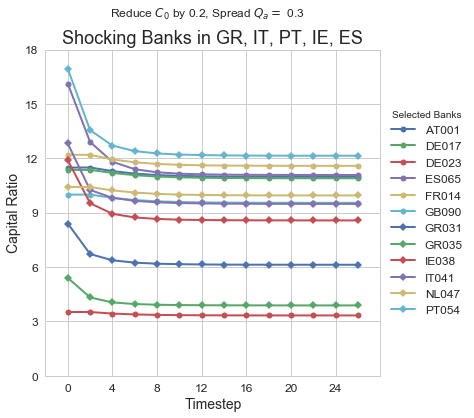

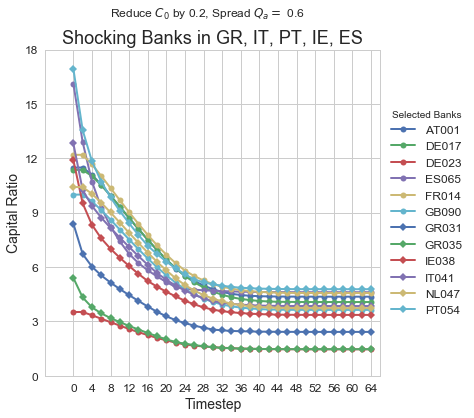

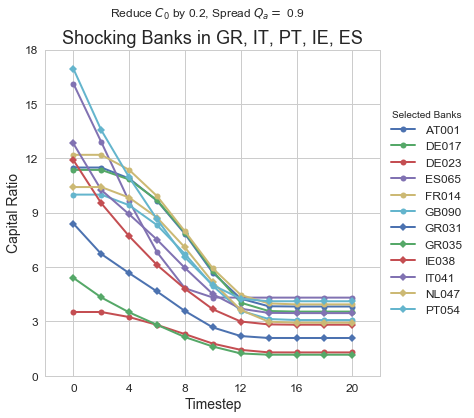

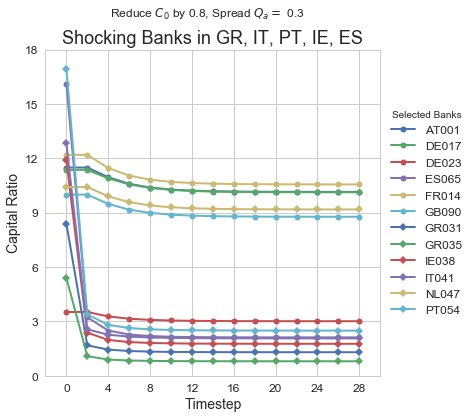

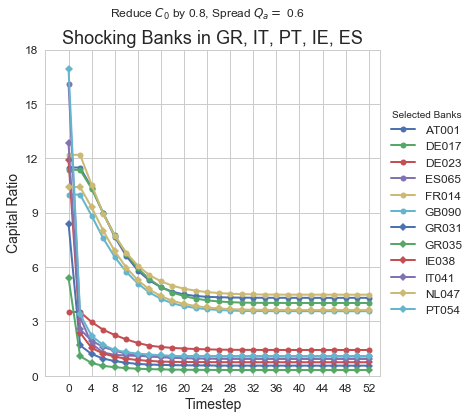

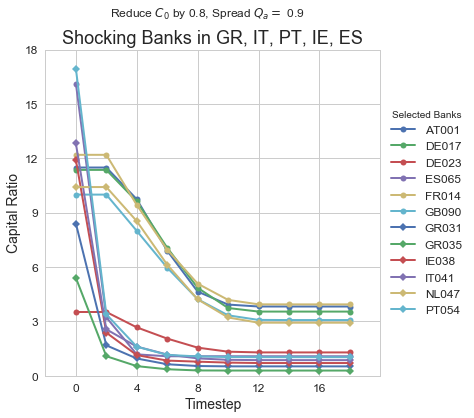

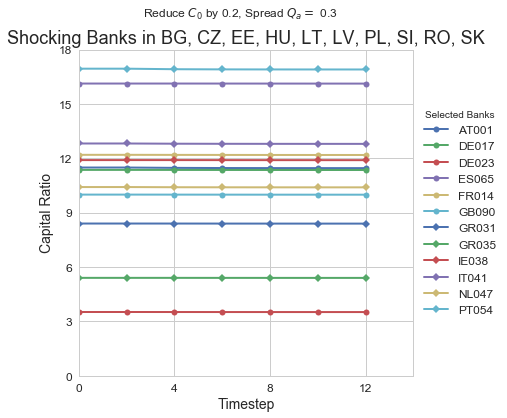

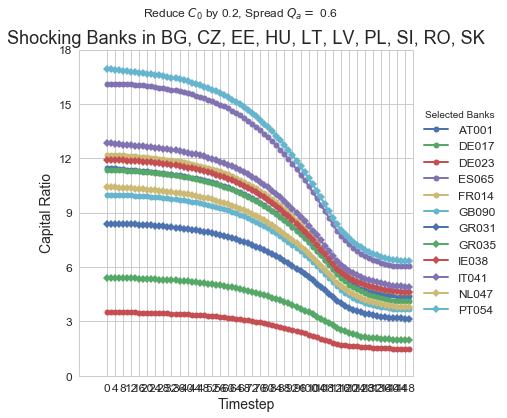

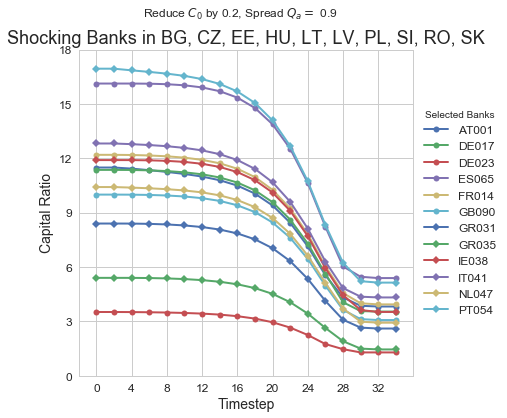

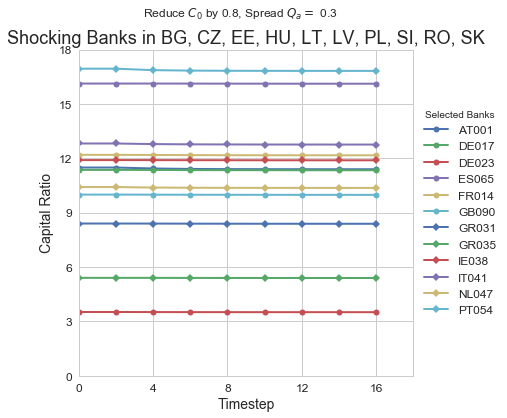

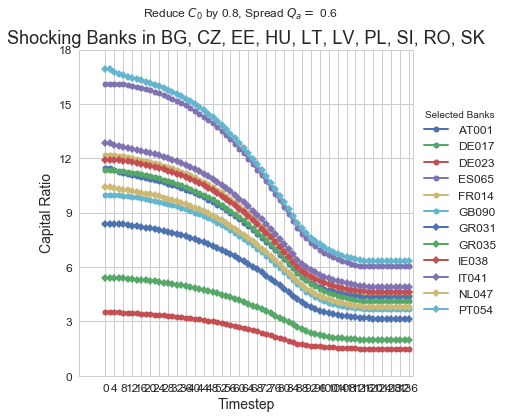

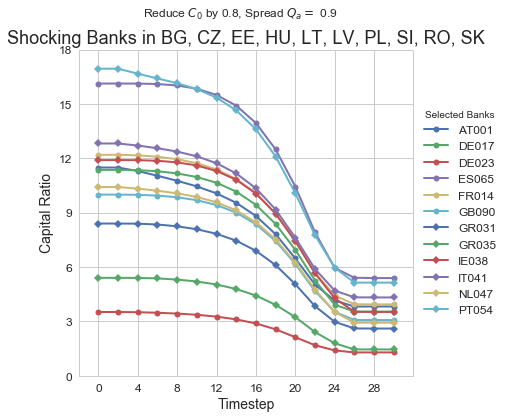

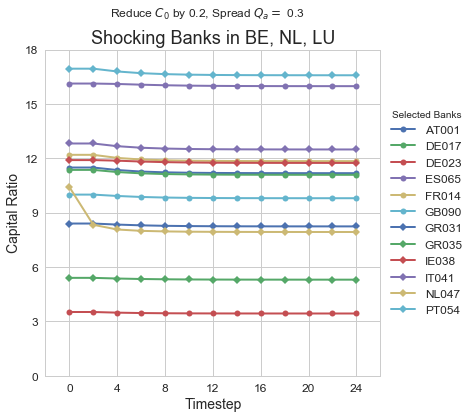

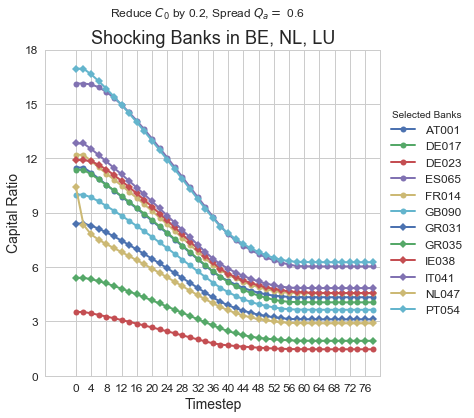

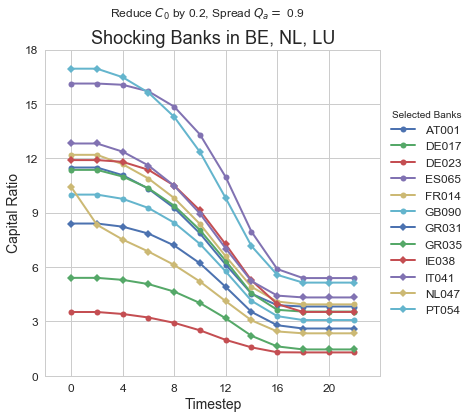

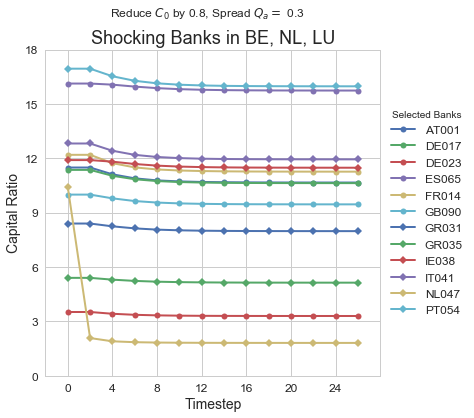

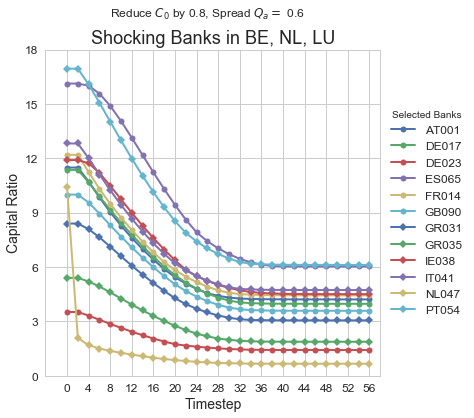

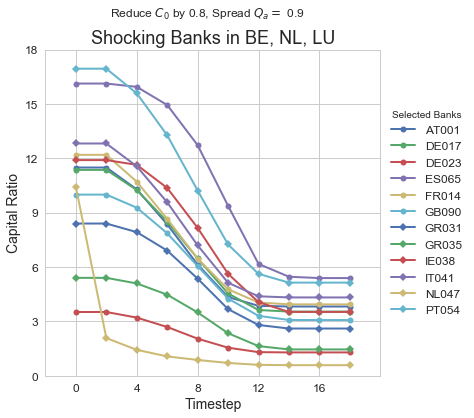

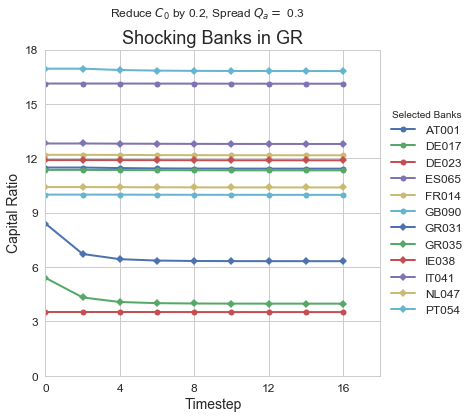

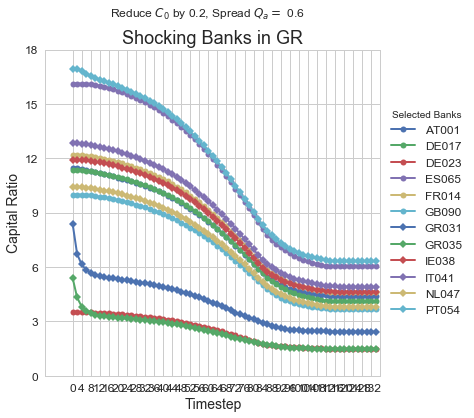

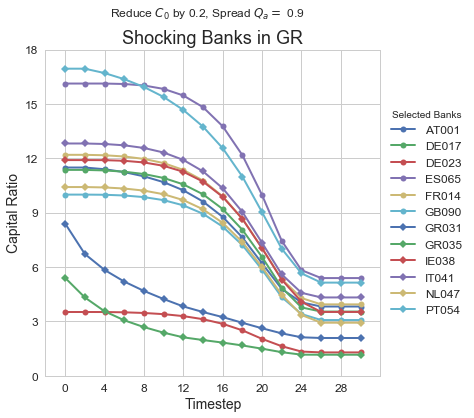

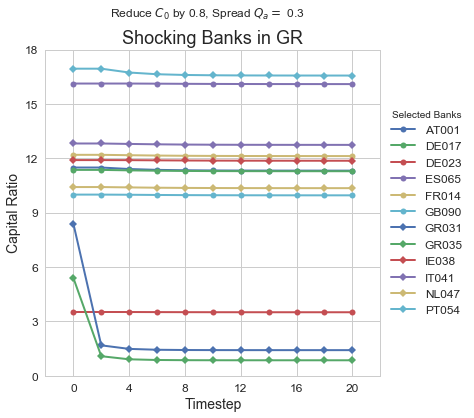

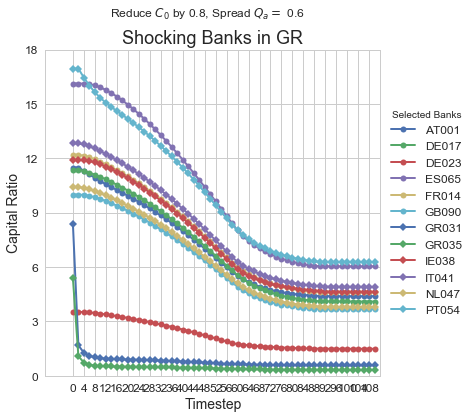

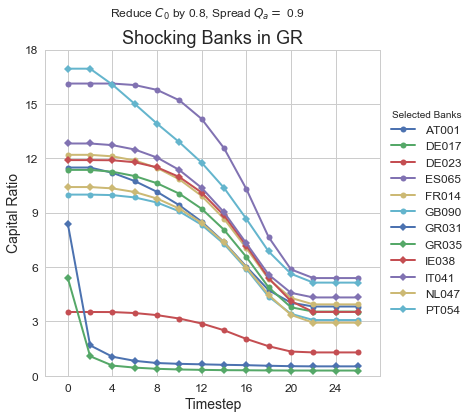

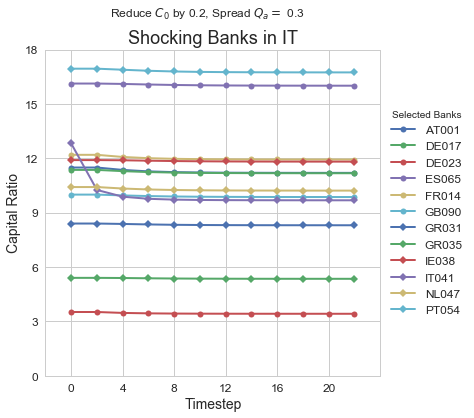

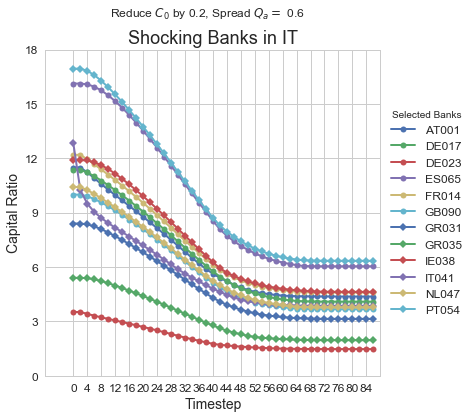

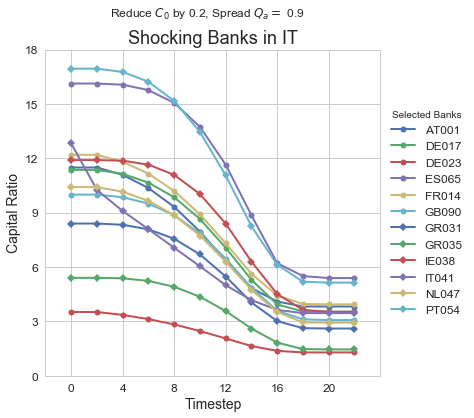

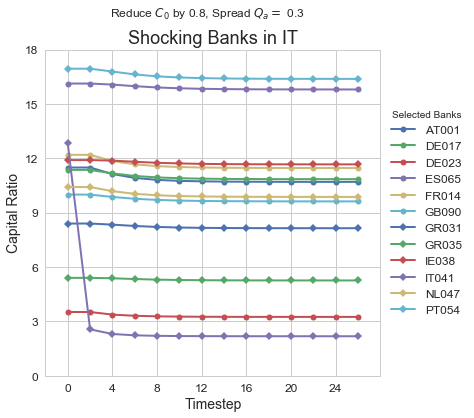

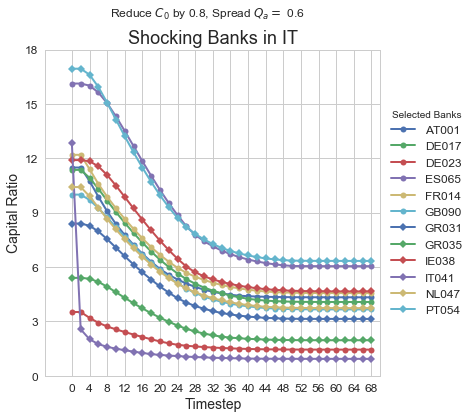

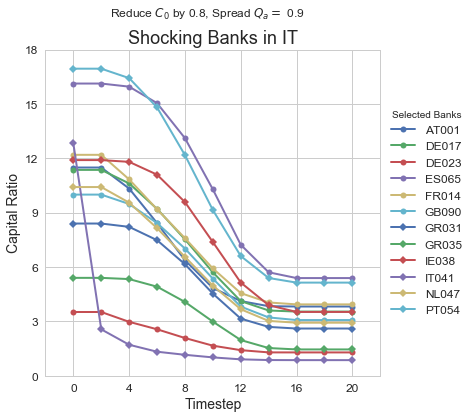

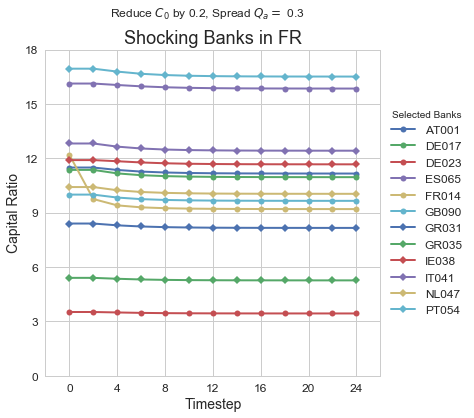

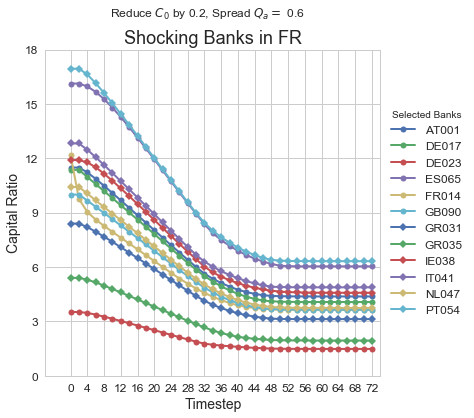

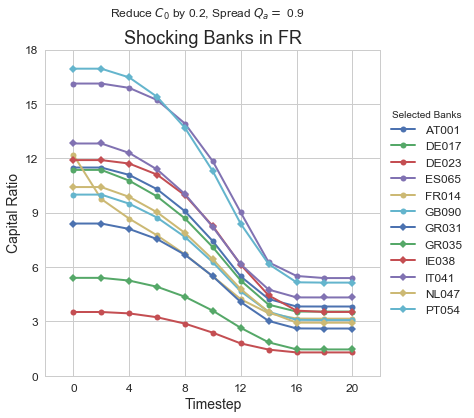

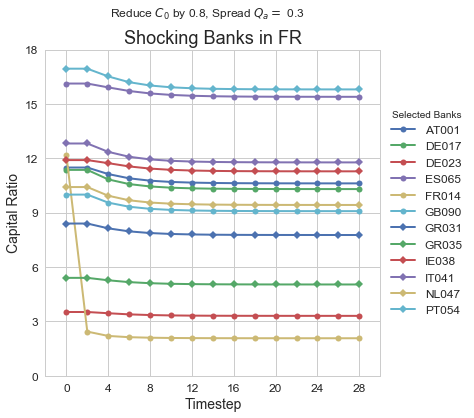

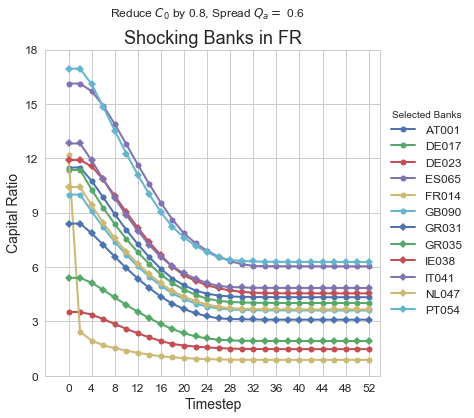

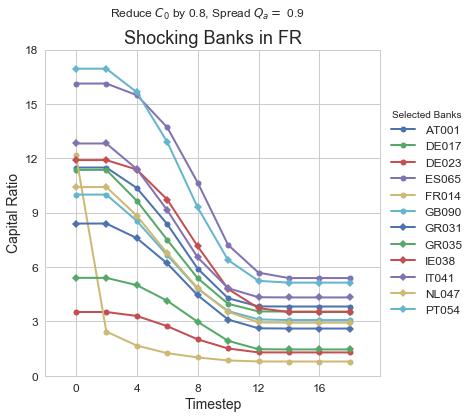

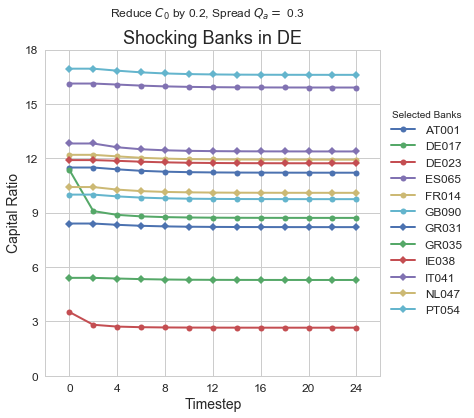

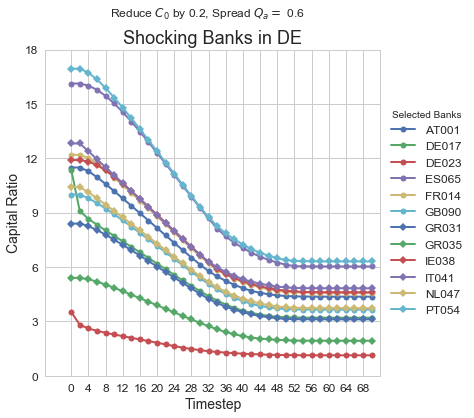

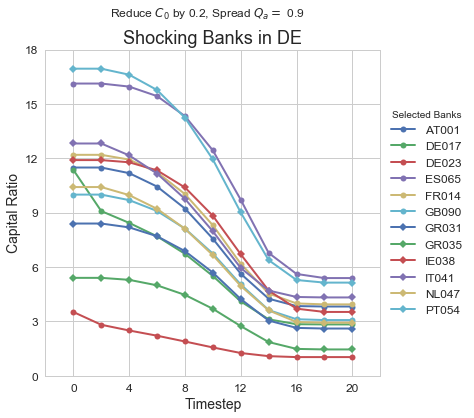

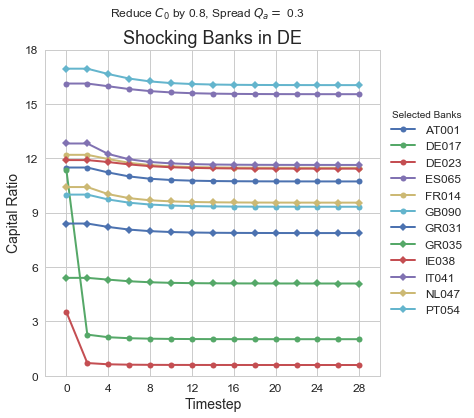

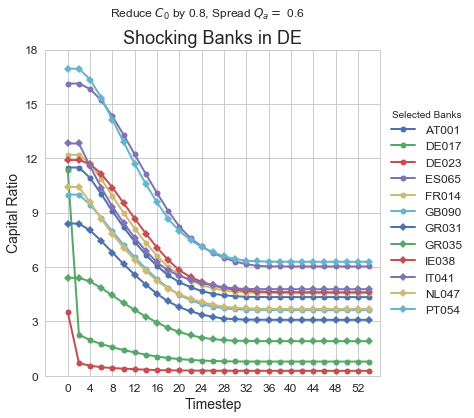

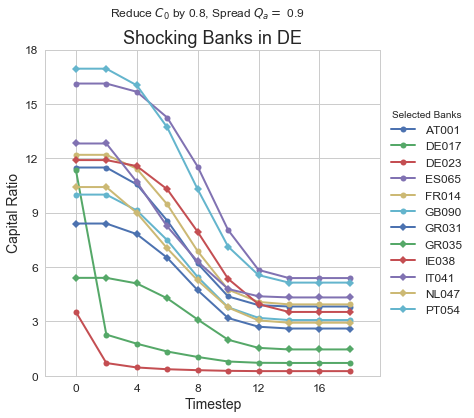

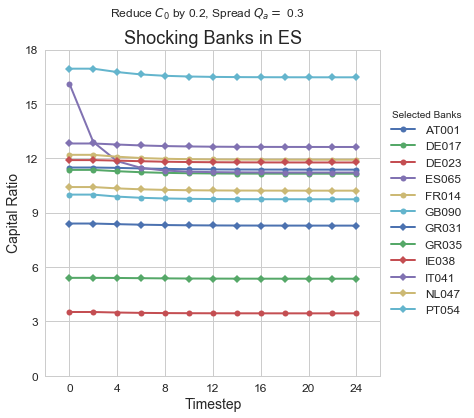

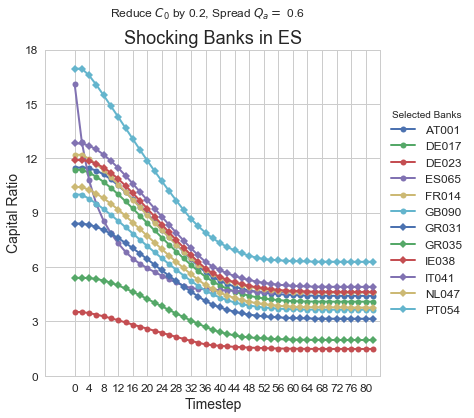

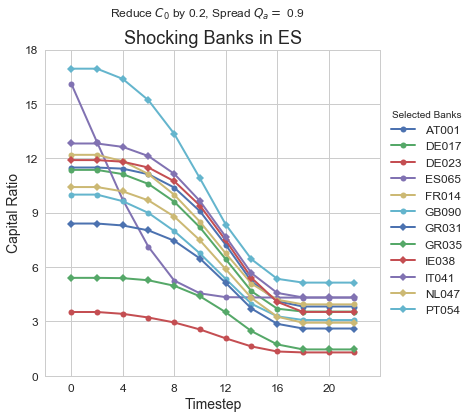

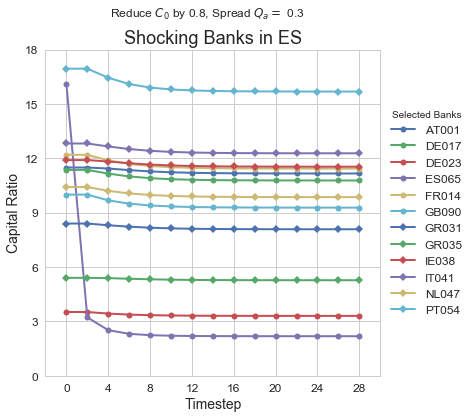

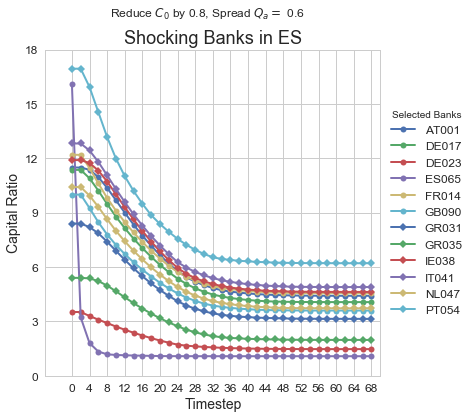

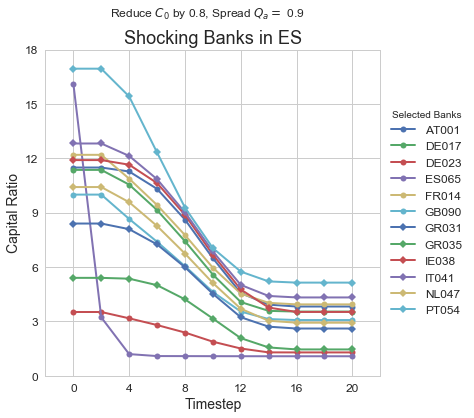

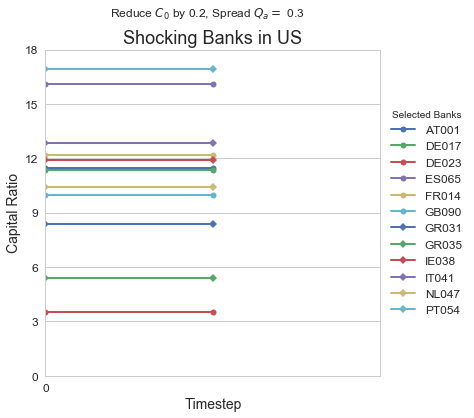

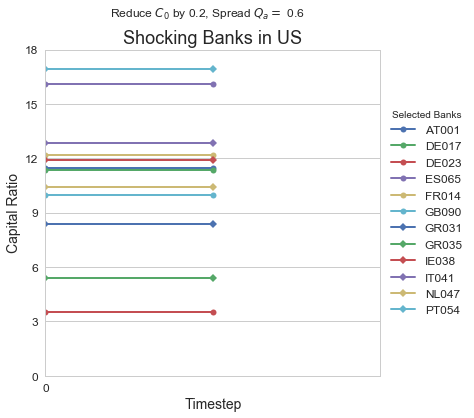

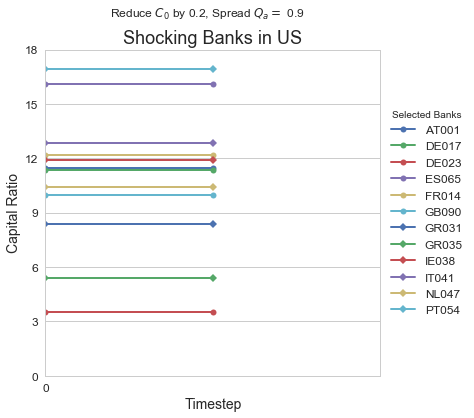

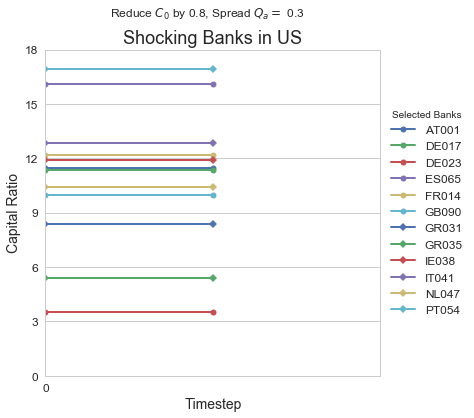

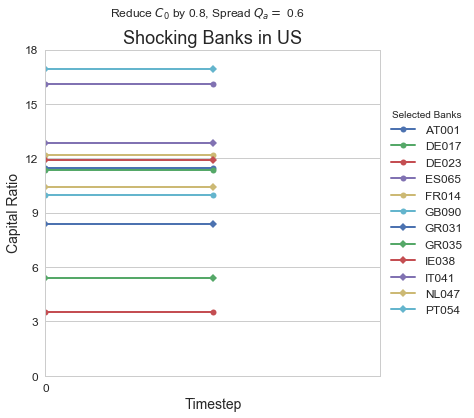

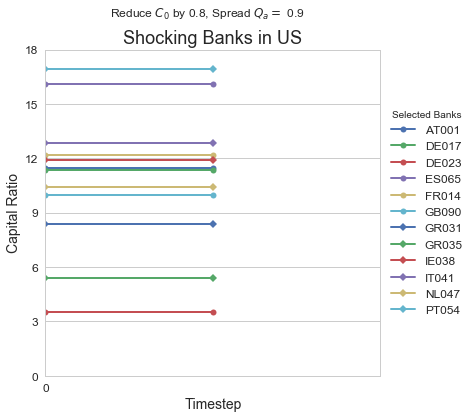

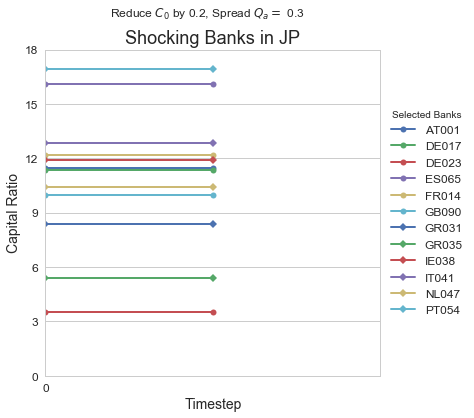

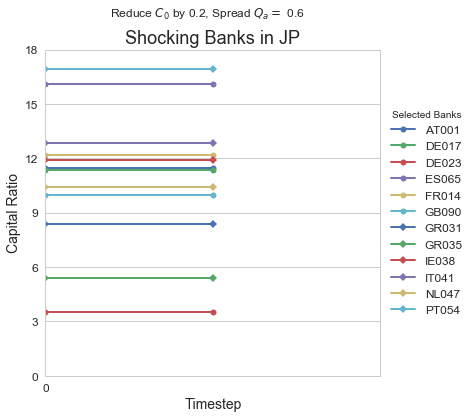

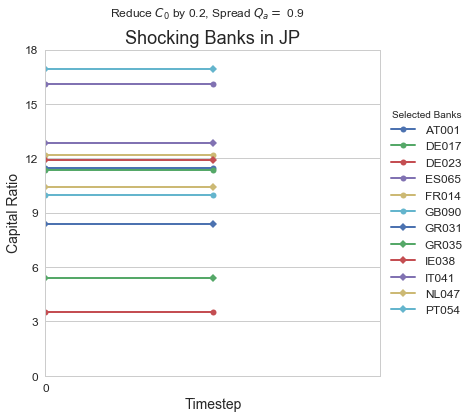

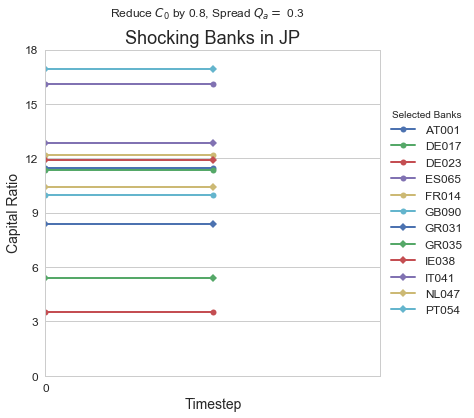

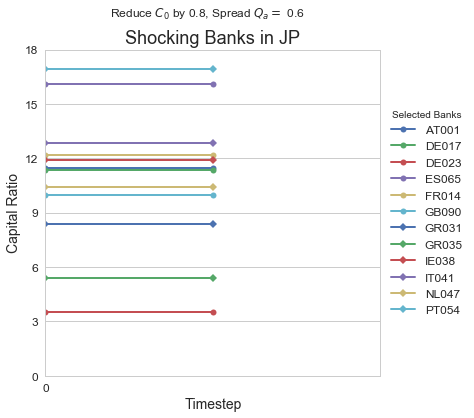

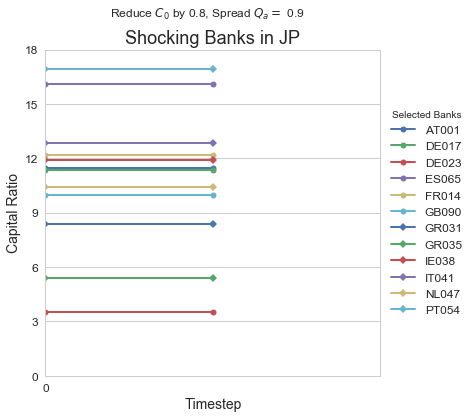

In [393]:
banks_to_plot = \
["AT001", "DE017", "DE023", "ES065", "GR035", "FR014", "GB090", "GR031", "IE038", "IT041", "NL047", "PT054"]
line_styles = \
["o-", "o-", "o-", "o-", "o-", "o-", "D-", "D-", "D-","D-","D-","D-"]

sh_params = [0.2, 0.8]
sp_params = [0.3, 0.6, 0.9]
for ct_list in start_country:
    for sh in sh_params:
        for sp in sp_params:
            world = Classes.World(df, geo_df, spread_df, sp, Classes.RiskWeights("min"))
            assets = world.getAssets()
            banks = world.getBanks()
            evo_a, evo_b, runs = world.runShockBanks(banks, assets, ct_list, sh)

            plot_df = evo_b
            plot_df.index = np.sort(bank_cap_df.index)
            plot_df = plot_df.loc[banks_to_plot].merge(bank_names_df, left_index=True, right_index=True).filter(regex="R")

            fig, ax = plt.subplots()
            plot_df.T.plot(ax=ax, 
                           ylim=(0,18), xlim=(-int(len(plot_df.T)/10), len(plot_df.T)), 
                           figsize=(6,6), ms=6, linewidth=2, style=line_styles)
            plt.title("Shocking Banks in " + ", ".join(ct_list), fontsize=18)

            ax.set_xticks(range(0, len(plot_df.T), 2))
            ax.set_xticklabels([int(c[2:]) for c in plot_df.columns[0::2]])


            ax.set_yticks(range(0,19, 3))

            ax.set_xlabel("Timestep", fontsize=14)
            ax.set_ylabel("Capital Ratio", fontsize=14)

            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(12)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(12)

            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title="Selected Banks")
            fig.suptitle("Reduce $C_0$ by "+str(sh)+", Spread $Q_a = $ "+str(sp))

            fig.savefig("img/Capital_Reduction__"+"_".join(ct_list)+"__SP"+str(int(100*sp))+"__SH"+str(int(100*sh))+
                        ".png", bbox_inches='tight')

In [173]:
rl = [[sp, cr, run_length(sp, cr)] for sp in np.arange(0.02, 1.01, 0.02) for cr in np.arange(0.2, 1, 0.6)]

In [174]:
rl_df = pd.DataFrame(rl, columns=["sp", "cr", "time"]).pivot(index="sp", columns="cr", values="time")

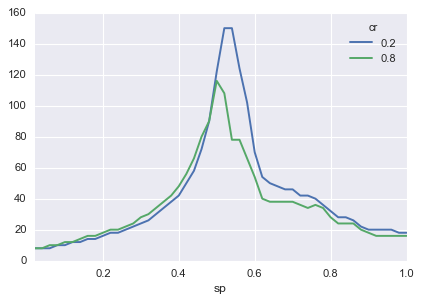

In [175]:
rl_df.plot()

In [134]:
evo_b.filter(regex="R")
evo_a.head()

r_0    r_1       r_3       r_5       r_7       r_9      r_11  \
1_Sov_AT  0.002  0.002  0.002045  0.002069  0.002082  0.002089  0.002093   
1_Sov_BE  0.002  0.002  0.002115  0.002177  0.002210  0.002228  0.002238   
1_Sov_BG  0.002  0.002  0.002124  0.002191  0.002227  0.002247  0.002257   
1_Sov_CY  0.002  0.002  0.002226  0.002352  0.002421  0.002458  0.002479   
1_Sov_CZ  0.002  0.002  0.002066  0.002102  0.002121  0.002131  0.002137   

              r_13      r_15      r_17      r_19  
1_Sov_AT  0.002095  0.002096  0.002097  0.002097  
1_Sov_BE  0.002244  0.002246  0.002248  0.002249  
1_Sov_BG  0.002263  0.002266  0.002268  0.002269  
1_Sov_CY  0.002490  0.002496  0.002499  0.002501  
1_Sov_CZ  0.002140  0.002141  0.002142  0.002143

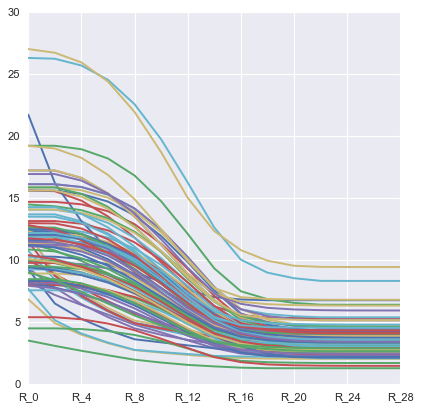

In [94]:
world = Classes.World(df, geo_df, spread_df, 0.8, Classes.RiskWeights("min"))
assets = world.getAssets()
banks = world.getBanks()

evo_a, evo_b, runs = world.runShock(banks, assets, "fin", ["DE", "FR"], 2)
evo_b.filter(like="R_").T.plot(figsize=(6,6), legend=False)

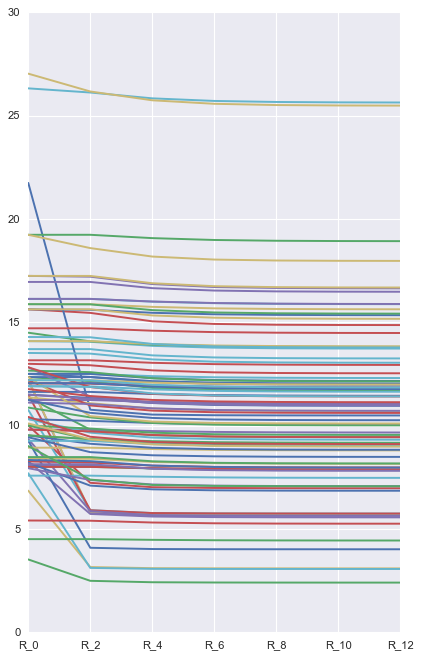

In [39]:
world = Classes.World(df, geo_df, spread_df, 0.2, Classes.RiskWeights("min"))
assets = world.getAssets()
banks = world.getBanks()

evo_a, evo_b, runs = world.runShock(banks, assets, "fin", ["DE", "FR"], 10)
evo_b.filter(like="R_").T.plot(figsize=(6,10), legend=False)

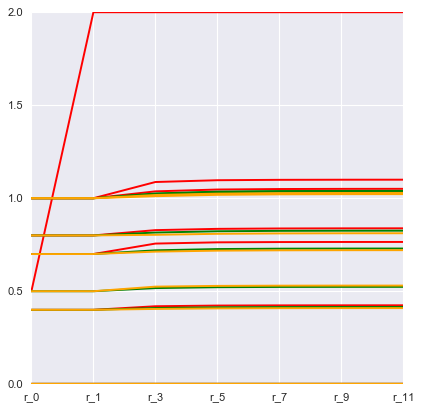

In [40]:
fig, ax = plt.subplots()

evo_a.filter(like="r_").T.filter(like="_DE").plot(figsize=(6,6), legend=False, ax=ax, c='r')
evo_a.filter(like="r_").T.filter(like="_NL").plot(figsize=(6,6), legend=False, ax=ax, c='g')
evo_a.filter(like="r_").T.filter(like="_GR").plot(figsize=(6,6), legend=False, ax=ax, c='orange')

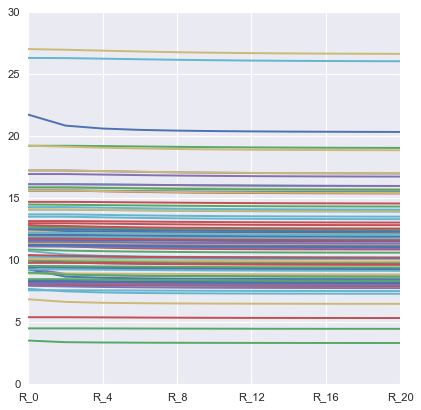

In [41]:
world = Classes.World(df, geo_df, spread_df, 0.4, Classes.RiskWeights("min"))
assets = world.getAssets()
banks = world.getBanks()

evo_a, evo_b, runs = world.runShock(banks, assets, "sov", ["DE", "FR"], 50)
evo_b.filter(like="R_").T.plot(figsize=(6,6), legend=False)

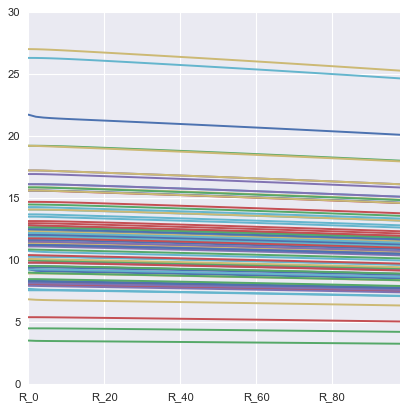

In [52]:
world = Classes.World(df, geo_df, spread_df, 0.56, Classes.RiskWeights("min"))
assets = world.getAssets()
banks = world.getBanks()

evo_a, evo_b, runs = world.runShock(banks, assets, "sov", ["DE", "FR"], 10)
evo_b.filter(like="R_").T.plot(figsize=(6,6), legend=False)

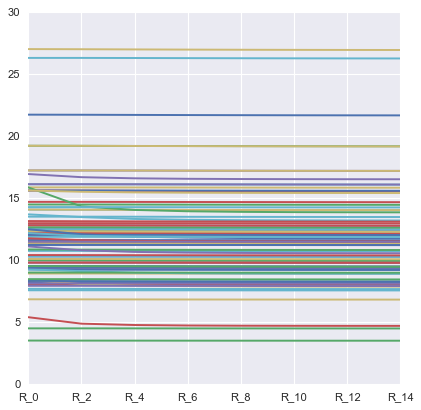

In [44]:
world = Classes.World(df, geo_df, spread_df, 0.4, Classes.RiskWeights("min"))
assets = world.getAssets()
banks = world.getBanks()

evo_a, evo_b, runs = world.runShock(banks, assets, "sov", ["GR", "PT"], 50)
evo_b.filter(like="R_").T.plot(figsize=(6,6), legend=False)

In [ ]:
world = Classes.World(df, geo_df, spread_df, 0.8, Classes.RiskWeights("min"))
assets = world.getAssets()
banks = world.getBanks()

evo_a, evo_b, runs = world.runShock(banks, assets, "sov", ["GR", "PT"], 50)
evo_b.filter(like="R_").T.plot(figsize=(6,6), legend=False)

Increase of the risk factors when we shock sov debt in GR, PT, and it spreads highly to other sectors

In [ ]:
evo_a.filter(like="r_").T.plot(figsize=(6,6), legend=False)

In [88]:
reload(Classes);
res = []
for sp in np.arange(0.4, 0.901, 0.05):
    for sh in np.arange(1.5, 4.5, 0.5):
        world = Classes.World(df, geo_df, spread_df, sp, Classes.RiskWeights("min"))
        assets = world.getAssets()
        banks = world.getBanks()
        evo_a, evo_b, runs = world.runShock(banks, assets, "fin", ["GB", "FR"], sh)
        res.append(
            [sp, sh, 1 - np.mean(evo_b.filter(like="R").iloc[:,-1])/np.mean(evo_b.filter(like="R").iloc[:,0])])

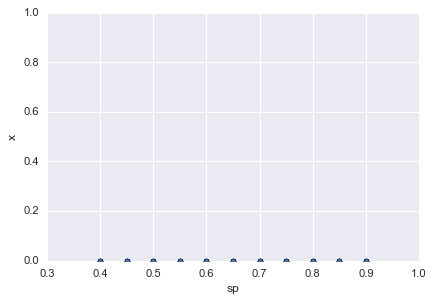

In [89]:
x_df = pd.DataFrame(data=res, columns=["sp", "sh", "x"])
fig, ax = plt.subplots()
x_df.plot(kind='scatter', x='sp', y='x', ax=ax, linestyle='-', ylim=(0,1))

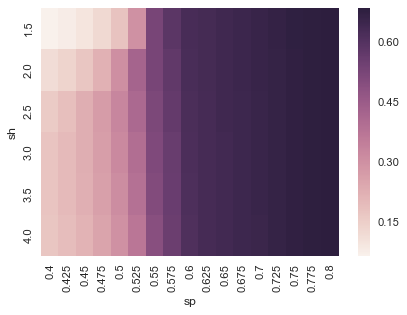

In [82]:
sns.heatmap(x_df.pivot(columns="sp", index="sh", values="x"))

In [158]:
x_df.pivot(columns="sp", index="sh", )

x                                                              \
sp      0.100     0.125     0.150     0.175     0.200     0.225     0.250   
sh                                                                          
1.1  0.004540  0.004653  0.004772  0.004898  0.005031  0.005172  0.005322   
1.2  0.008835  0.009056  0.009288  0.009535  0.009795  0.010071  0.010363   
1.3  0.012909  0.013232  0.013574  0.013935  0.014316  0.014721  0.015151   
1.4  0.016782  0.017203  0.017649  0.018119  0.018618  0.019146  0.019708   
1.5  0.020472  0.020987  0.021532  0.022108  0.022718  0.023365  0.024054   
1.6  0.023994  0.024600  0.025239  0.025916  0.026634  0.027396  0.028206   
1.7  0.027363  0.028055  0.028786  0.029560  0.030381  0.031253  0.032180   
1.8  0.030591  0.031365  0.032184  0.033052  0.033972  0.034950  0.035990   
1.9  0.033688  0.034542  0.035445  0.036403  0.037420  0.038500  0.039650   
2.0  0.036664  0.037595  0.038580  0.039625  0.040734  0.041913  0.043169   
2.1  0.039528  0.040533  0.041598  0.042726  0.043925  0.045200  0.046557   
2.2  0.042289  0.043365  0.044506  0.045716  0.047001  0.048369  0.049825   
2.3  0.044952  0.046098  0.047313  0.048601  0.049971  0.051428  0.052981   
2.4  0.047525  0.048738  0.050024  0.051389  0.052840  0.054384  0.056031   
2.5  0.050014  0.051292  0.052647  0.054086  0.055616  0.057245  0.058982   
2.6  0.052424  0.053765  0.055187  0.056698  0.058305  0.060016  0.061841   
2.7  0.054759  0.056161  0.057649  0.059230  0.060911  0.062702  0.064614   
2.8  0.057025  0.058486  0.060038  0.061686  0.063440  0.065310  0.067305   
2.9  0.059224  0.060744  0.062357  0.064072  0.065897  0.067842  0.069919   
3.0  0.061362  0.062938  0.064612  0.066391  0.068285  0.070304  0.072460   
3.1  0.063441  0.065072  0.066805  0.068647  0.070608  0.072700  0.074933   
3.2  0.065465  0.067150  0.068939  0.070843  0.072870  0.075032  0.077342   
3.3  0.067437  0.069174  0.071019  0.072983  0.075074  0.077305  0.079689   
3.4  0.069358  0.071147  0.073047  0.075069  0.077223  0.079522  0.081978   
3.5  0.071233  0.073071  0.075025  0.077104  0.079320  0.081684  0.084211   
3.6  0.073063  0.074950  0.076956  0.079091  0.081367  0.083796  0.086392   
3.7  0.074850  0.076785  0.078842  0.081032  0.083366  0.085216  0.087138   
3.8  0.076597  0.078578  0.080387  0.082017  0.083739  0.085560  0.087489   
3.9  0.077695  0.079163  0.080712  0.082346  0.084073  0.085843  0.087710   
4.0  0.077846  0.079266  0.080761  0.082336  0.083998  0.085753  0.087609   

                                     ...                                   \
sp      0.275     0.300     0.325    ...        0.775     0.800     0.825   
sh                                   ...                                    
1.1  0.005481  0.005650  0.005830    ...     0.013398  0.014314  0.015329   
1.2  0.010675  0.011006  0.011360    ...     0.026248  0.028049  0.030046   
1.3  0.015609  0.016096  0.016616    ...     0.038590  0.041250  0.044197   
1.4  0.020306  0.020943  0.021623    ...     0.050463  0.053954  0.057821   
1.5  0.024786  0.025567  0.026402    ...     0.061900  0.066198  0.070956   
1.6  0.029068  0.029988  0.030972    ...     0.072931  0.078011  0.083634   
1.7  0.033168  0.034222  0.035349    ...     0.083582  0.089423  0.095884   
1.8  0.037099  0.038283  0.039549    ...     0.093880  0.100458  0.107733   
1.9  0.040875  0.042184  0.043585    ...     0.103845  0.111140  0.119206   
2.0  0.044507  0.045938  0.047469    ...     0.113498  0.121490  0.130323   
2.1  0.048006  0.049554  0.051211    ...     0.122857  0.131528  0.141107   
2.2  0.051380  0.053042  0.054822    ...     0.131940  0.141270  0.151574   
2.3  0.054639  0.056411  0.058310    ...     0.140762  0.150734  0.161741   
2.4  0.057789  0.059669  0.061684    ...     0.149336  0.159933  0.171625   
2.5  0.060838  0.062823  0.064950    ...     0.157676  0.168881  0.181240   
2.6  0.063791  0.065878  0.068116    ...     0.165793  0.177591  0.188932   
2.7  0.